In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from IPython.display import clear_output
eps = 1e-5

In [13]:
# Load the Fashion-MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)      
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


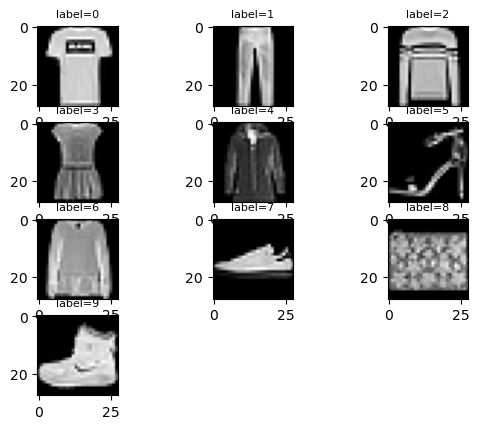

In [15]:
# Getting the unique labels and one entry from each
labels = set(y_train)
sample = {ind: np.where(y_train == ind)[0][0] for ind in labels}

# Plotting one image from each label
for i in range(10):
    plt.subplot(4,3,i+1)
    plt.imshow(x_train[sample[i]], cmap='gray')
    plt.title(f"label={i}", fontsize=8)

plt.show()


In [16]:
def one_hot_encode(y):
    one_hot_vectors = []
    for i in y:
        vec = np.zeros((10,))
        vec[i] = 1
        one_hot_vectors.append(vec)
    return np.array(one_hot_vectors)

In [17]:
# reshaping the data
x_train = x_train.reshape(x_train.shape[0], 28*28)
x_train = x_train/x_train.sum()
x_test = x_test.reshape(x_test.shape[0], 28*28)
x_test = x_test/x_test.sum()
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# Converting the labels to one-hot encoding
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 784)
x_test shape: (10000, 784)
y_train shape: (60000, 10)
y_test shape: (10000, 10)


In [36]:
# Activation functions
class Activation():

    @classmethod
    def sigmoid(self, x):
        return 1/(1+np.exp(-x) + eps)
    @classmethod
    def softmax(self, x):
        max_x = np.max(x, axis=1, keepdims=True)
        x = x - max_x
        return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
    @classmethod
    def relu(self, x):
        return np.maximum(0, x)
    @classmethod
    def tanh(self, x):
        return np.tanh(x)


# Layer class
class Layer():
    def __init__(self, name, input_size, n_units, activation=None):
        self.name = name
        self.weights = np.random.randn(n_units, input_size)
        self.bias = np.random.randn(n_units)
        self.g = activation

    def __call__(self, input):

        hidden = input @ self.weights.T + self.bias
        self.preact = hidden
        self.act = self.activation(hidden)
        return self.act
    
    def activation(self, z):
        if self.g == 'sigmoid':
            return Activation.sigmoid(z)
        elif self.g == 'softmax':
            return Activation.softmax(z)
        elif self.g == 'relu':
            return Activation.relu(z)
        elif self.g == 'tanh':
            return Activation.tanh(z)
        elif self.g == None:
            return z
            



In [42]:
# Neural Network class
class NeuralNet():
    def __init__(self, input_size, n_units: list, loss:str, optimizer=None):
        self.n_layers = len(n_units)
        self.n_units = n_units
        self.input_size = input_size
        self.layers = self._network()
        self.loss_fn = loss
        self.loss = 0
        self.optimizer = optimizer

        
    def _network(self):
        layers = []
        for i in range(self.n_layers):
            if i==0:
                layers.append(Layer(i+1, self.input_size, self.n_units[i], activation="relu"))
            elif i < self.n_layers-1:
                layers.append(Layer(i+1, self.n_units[i-1], self.n_units[i], activation="relu"))
            else:
                layers.append(Layer(i+1, self.n_units[i-1], self.n_units[i], activation="softmax"))
            
        return layers
    
    def get_weights(self):
        return [layer.weights for layer in self.layers]
    
    def get_biases(self):
        return [layer.bias for layer in self.layers]
    
    def backpropogation(self, x, y):
        pass



        
    def __call__(self, x, y):
        for layer in self.layers:
            x = layer(x)
        
        self.loss = self.loss_fn(x, y)
        return x

In [20]:
# Loss function
class Loss():
    def __init__(self, loss_fn = 'cross_entropy'):
        self.loss_fn = loss_fn

    def __call__(self, y_true, y_pred):
        if self.loss_fn == 'cross_entropy':
            return np.mean(self.cross_entropy(y_true, y_pred))
        elif self.loss_fn == 'mse':
            return np.mean(self.mse(y_true, y_pred))
        
    def cross_entropy(self, y_true, y_pred):
        return -np.log(np.sum(y_true*y_pred, axis=1))
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true-y_pred)**2)

In [21]:
def batch_data(x, y, batch_size):
    batches = []
    for i in range(0, x.shape[0], batch_size):
        batches.append((x[i:i+batch_size], y[i:i+batch_size]))
    return batches

In [22]:
threshold = 1e5
def clip_gradients(gradients, threshold):
    return np.clip(gradients, -threshold, threshold)

def check_for_nans(array):
    if np.isnan(array).any():
        raise ValueError("NaN detected in array")


In [26]:
def compute_grads(model, W1, W2, W3, W4, x, y, output):    
    a4 = model.layers[3].preact
    a3 = model.layers[2].preact.reshape(4, 32, 1)
    a2 = model.layers[1].preact.reshape(4, 32, 1)
    a1 = model.layers[0].preact.reshape(4, 32, 1)

    h1 = model.layers[0].act.reshape(4, 32, 1)
    h2 = model.layers[1].act.reshape(4, 32, 1)
    h3 = model.layers[2].act.reshape(4, 32, 1)
    h4 = model.layers[3].act.reshape(4, 10, 1)


    #grad_h4 = grad_yhat(y_train[:10], out[:10])
    grad_a4 = grad_output(y, output).reshape(4, 10, 1)

    grad_h3 = grad_hidden(W4, grad_a4)
    grad_a3 = grad_preact(grad_h3 ,a3, 'relu')

    grad_h2 = grad_hidden(W3, grad_a3)
    grad_a2 = grad_preact(grad_h2, a2, 'relu')

    grad_h1 = grad_hidden(W2, grad_a2)
    grad_a1 = grad_preact(grad_h1, a1, 'relu')


    grad_w1 = np.sum(grad_weights(grad_a1, x.reshape(4, 784, 1)), axis = 0)
    grad_b1 = np.sum(grad_bias(grad_a1), axis=0)
    grad_w2 = np.sum(grad_weights(grad_a2, h1), axis = 0)
    grad_b2 = np.sum(grad_bias(grad_a2), axis=0)
    grad_w3 = np.sum(grad_weights(grad_a3, h2), axis = 0)
    grad_b3 = np.sum(grad_bias(grad_a3), axis=0)
    grad_w4 = np.sum(grad_weights(grad_a4, h3), axis = 0)
    grad_b4 = np.sum(grad_bias(grad_a4), axis=0)

    return grad_w1, grad_w2, grad_w3, grad_w4, grad_b1, grad_b2, grad_b3, grad_b4


In [ ]:
batch_size = 4
loss = Loss(loss_fn='cross_entropy')
#optimizer = GradientDescent(lr=0.0001)
model = NeuralNet(x_train.shape[1], [32, 32, 32, 10], loss)

In [46]:
loss = Loss(loss_fn='cross_entropy')
#optimizer = GradientDescent(lr=0.0001)
model = NeuralNet(x_train.shape[1], [32, 32, 32, 10], loss)
dataloader = batch_data(x_train, y_train, 4)
losses = []
W4 = model.layers[3].weights
W3 = model.layers[2].weights
W2 = model.layers[1].weights
W1 = model.layers[0].weights
b1 = model.layers[0].bias
b2 = model.layers[1].bias
b3 = model.layers[2].bias
b4 = model.layers[3].bias
lr = 0.0001
for epoch in range(10):
    i=0
    print(f"Epoch: {epoch}")
    batch_loss = []
    for x,y in dataloader:
        output = model(x,y)
        loss = model.loss
        break





        i+=1
        if i%1000 == 0:
            print(f"batch {i} loss: {loss}")
        batch_loss.append(loss)
        grad_w1, grad_w2, grad_w3, grad_w4, grad_b1, grad_b2, grad_b3, grad_b4 = compute_grads(model, W1, W2, W3, W4, x, y, output)
        # Clip gradients
        grad_w1 = clip_gradients(grad_w1, threshold)
        grad_w2 = clip_gradients(grad_w2, threshold)
        grad_w3 = clip_gradients(grad_w3, threshold)
        grad_w4 = clip_gradients(grad_w4, threshold)
        grad_b1 = clip_gradients(grad_b1, threshold)
        grad_b2 = clip_gradients(grad_b2, threshold)
        grad_b3 = clip_gradients(grad_b3, threshold)
        grad_b4 = clip_gradients(grad_b4, threshold)

        # Check for NaNs
        check_for_nans(grad_w1)
        check_for_nans(grad_w2)
        check_for_nans(grad_w3)
        check_for_nans(grad_w4)
        check_for_nans(grad_b1)
        check_for_nans(grad_b2)
        check_for_nans(grad_b3)
        check_for_nans(grad_b4)



        W1 = W1 - lr*grad_w1
        b1 = b1 - lr*grad_b1.squeeze()
        W2 = W2 - lr*grad_w2
        b2 = b2 - lr*grad_b2.squeeze()
        W3 = W3 - lr*grad_w3
        b3 = b3 - lr*grad_b3.squeeze()
        W4 = W4 - lr*grad_w4
        b4 = b4 - lr*grad_b4.squeeze()
        model.layers[0].weights = W1
        model.layers[0].bias = b1
        model.layers[1].weights = W2
        model.layers[1].bias = b2
        model.layers[2].weights = W3
        model.layers[2].bias = b3
        model.layers[3].weights = W4
        model.layers[3].bias = b4

    clear_output(True)
    print(f"average epoch loss: {np.mean(batch_loss)}")
    losses.append(np.mean(batch_loss))


average epoch loss: nan


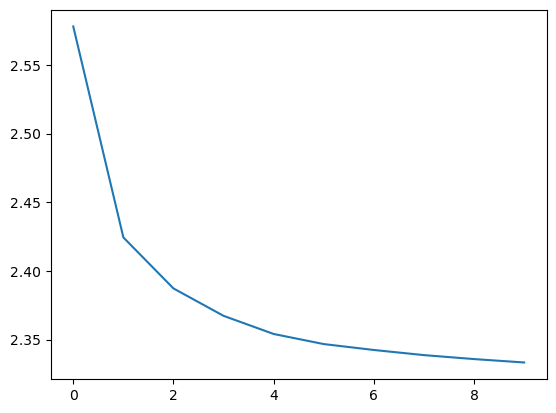

In [494]:
plt.plot(losses)

In [ ]:
class GradientDescent():
    def __init__(self, optimizer = 'sgd', lr = 0.01):
        self.model = model
        self.optimizer = optimizer
        self.lr = lr

    def backprop(self, x, y):
        
        ######################

    def update_weights(self):
        ######################
        pass


    def compute_grads(model, W1, W2, W3, W4, x, y, output):    
        a4 = model.layers[3].preact
        a3 = model.layers[2].preact.reshape(4, 32, 1)
        a2 = model.layers[1].preact.reshape(4, 32, 1)
        a1 = model.layers[0].preact.reshape(4, 32, 1)

        h1 = model.layers[0].act.reshape(4, 32, 1)
        h2 = model.layers[1].act.reshape(4, 32, 1)
        h3 = model.layers[2].act.reshape(4, 32, 1)
        h4 = model.layers[3].act.reshape(4, 10, 1)


        #grad_h4 = grad_yhat(y_train[:10], out[:10])
        grad_a4 = grad_output(y, output).reshape(4, 10, 1)

        grad_h3 = grad_hidden(W4, grad_a4)
        grad_a3 = grad_preact(grad_h3 ,a3, 'relu')

        grad_h2 = grad_hidden(W3, grad_a3)
        grad_a2 = grad_preact(grad_h2, a2, 'relu')

        grad_h1 = grad_hidden(W2, grad_a2)
        grad_a1 = grad_preact(grad_h1, a1, 'relu')


        grad_w1 = np.sum(grad_weights(grad_a1, x.reshape(4, 784, 1)), axis = 0)
        grad_b1 = np.sum(grad_bias(grad_a1), axis=0)
        grad_w2 = np.sum(grad_weights(grad_a2, h1), axis = 0)
        grad_b2 = np.sum(grad_bias(grad_a2), axis=0)
        grad_w3 = np.sum(grad_weights(grad_a3, h2), axis = 0)
        grad_b3 = np.sum(grad_bias(grad_a3), axis=0)
        grad_w4 = np.sum(grad_weights(grad_a4, h3), axis = 0)
        grad_b4 = np.sum(grad_bias(grad_a4), axis=0)

        return grad_w1, grad_w2, grad_w3, grad_w4, grad_b1, grad_b2, grad_b3, grad_b4

    def _grad_yhat(y_true, y_pred, loss = 'cross_entropy'):
        if loss == 'cross_entropy':
            y_grad = np.sum(y_true * y_pred, axis=1)
        #elif loss == 'mse':
        #    y_grad = y_pred
        return -(y_true/y_grad[:, np.newaxis])


    def _grad_output(y_true, y_pred):
        return -(y_true-y_pred)


    def _grad_hidden(W, grad_next_preact):
        return W.T @ grad_next_preact


    def _grad_preact(grad_act, act, activation):
        if activation == 'sigmoid':    # for sigmoid
            return grad_act*act*(1-act)
        elif activation == 'relu':    # for relu 
            return grad_act*(act>0)
        elif activation == 'tanh':    # for tanh
            return grad_act*(1-act**2)


    def _grad_weights(grad_preact, input):
        return grad_preact @ input.transpose(0, 2, 1) 


    def _grad_bias(grad_preact):
        return grad_preact

In [32]:
def grad_yhat(y_true, y_pred, loss = 'cross_entropy'):
    if loss == 'cross_entropy':
        y_grad = np.sum(y_true * y_pred, axis=1)
    #elif loss == 'mse':
    #    y_grad = y_pred
    return -(y_true/y_grad[:, np.newaxis])


def grad_output(y_true, y_pred):
    return -(y_true-y_pred)


def grad_hidden(W, grad_next_preact):
    return W.T @ grad_next_preact


def grad_preact(grad_act, act, activation):
    if activation == 'sigmoid':    # for sigmoid
        return grad_act*act*(1-act)
    elif activation == 'relu':    # for relu 
        return grad_act*(act>0)
    elif activation == 'tanh':    # for tanh
        return grad_act*(1-act**2)


def grad_weights(grad_preact, input):
    return grad_preact @ input.transpose(0, 2, 1) 


def grad_bias(grad_preact):
    return grad_preact

In [74]:
grad_a = {}
grad_h = {}
grad_w = {}
grad_b = {}
for layer in model.layers[::-1]:
    print(layer.name)
    if layer.name == model.n_layers:
        grad_a[layer.name] = grad_output(y_train[:4], output).reshape(batch_size, 10, 1)
        grad_w[layer.name] = np.sum(grad_weights(grad_a[layer.name], model.layers[layer.name - 2].act.reshape(batch_size, 32, 1)), axis = 0)
        grad_b[layer.name] = np.sum(grad_bias(grad_a[layer.name]), axis=0)
    
    else:
        grad_h[layer.name] = grad_hidden(model.layers[layer.name].weights, grad_a[layer.name + 1])
        grad_a[layer.name] = grad_preact(grad_h[layer.name], model.layers[layer.name-1].preact.reshape(batch_size, 32, 1), 'relu')
        if layer.name == 1:
            grad_w[layer.name]= np.sum(grad_weights(grad_a[layer.name], x.reshape(batch_size, model.input_size, 1)), axis = 0)
        else:
            grad_w[layer.name] = np.sum(grad_weights(grad_a[layer.name], model.layers[layer.name - 2].act.reshape(batch_size, 32, 1)), axis = 0)
        grad_b[layer.name] = np.sum(grad_bias(grad_a[layer.name]), axis=0)
    
    

4
3
2
1


(4, 10)

In [62]:
model.layers[layer.name - 1].act.shape

(4, 10)

In [63]:
layer.name - 1

3

In [50]:
model.layers[layer.name - 1].act

array([[1.44929166e-54, 4.02928793e-09, 9.56603771e-79, 8.29918671e-26,
        3.54723908e-38, 4.66532219e-24, 1.68393849e-31, 1.17652356e-55,
        9.99999996e-01, 2.49584203e-59],
       [1.44896481e-54, 4.02896636e-09, 9.56360903e-79, 8.29844478e-26,
        3.54703672e-38, 4.66443199e-24, 1.68375120e-31, 1.17637279e-55,
        9.99999996e-01, 2.49545143e-59],
       [1.44900579e-54, 4.02907529e-09, 9.56422188e-79, 8.29869368e-26,
        3.54698809e-38, 4.66468650e-24, 1.68377729e-31, 1.17638030e-55,
        9.99999996e-01, 2.49549309e-59],
       [1.44915296e-54, 4.02908389e-09, 9.56505778e-79, 8.29883575e-26,
        3.54723325e-38, 4.66489616e-24, 1.68386591e-31, 1.17644841e-55,
        9.99999996e-01, 2.49573909e-59]])

In [ ]:
#TODO Generalize for n layers, m units per layer
#TODO Other gradient descent algorithms